In [11]:
import torch
import triton
import triton.language as tl
import math


- 建议配合官方示例一起看

# 重要概念

## 指针
- 有C或者C++经验的同学应该对这个概念不陌生，建议不懂的去稍微了解下，我下面抽象的讲解下
- 假设内存上最多能存10000个元素，x1，x2都存在了内存上，如果记录了指针的起始位置和该tensor的shape或者元素个数，就能进行读取

In [12]:
memory = torch.zeros(10000)
# x1存在了0-100
memory[0:100] = torch.randn(100)
# x2存在了100-1000
memory[100:1000] = torch.randn(900)
x1 = memory[:100].reshape(10,10)
x2 = memory[100:1000].reshape(3,3,100)

- 指针错乱，比如x1指针指错了，错误的读取了x2的内容，并进行修改，就会破坏其它的tensor，这是很危险的行为
- 如果triton代码总是报“memory”的问题，那么大概是指针指歪了

In [15]:
# x1读取错了
x1 = memory[100:200]
# x2的内容被修改
memory[100:200] = x1 * x1

## 连续
- tensor是否连续是很重要的，处理起来会不同
- 张量连续的定义是，目前你处理的这个张量是否在内存上是连续存储（一字排列）

In [22]:
# 0-1000 在内存1000-2000连续存储
memory[1000:2000] = torch.arange(1000)
x3 = memory[1000:2000].reshape(10,10,10).transpose(0,1)
# 但是你目前处理的x3的排列方式，并不是从0-1000进行排列的，因此x3不是连续的
print('x3是否连续:', x3.is_contiguous())
print(x3.flatten()[:30])

x3是否连续: False
tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9., 100., 101.,
        102., 103., 104., 105., 106., 107., 108., 109., 200., 201., 202., 203.,
        204., 205., 206., 207., 208., 209.])


- 查看一个张量是否连续两种方法,第一种就是x3.is_contiguous()
- 第二种就是看张量的stride，如果是非递增的，一般都是连续的

In [26]:
# 递减，连续
print(x2.stride())
# 有变大，因此不连续
print(x3.stride())

(300, 100, 1)
(10, 100, 1)


- 什么是stride呢？跟卷积里的那个不太一样，不太好说，看例子吧


In [ ]:
print(x2.shape)
# 从x2[0][0][0] -> x2[1][0][0]
print(x2[1][0][0]  == memory[100+x2.stride(0)])
# 从x2[0][0][0] -> x2[0][1][0]
print(x2[0][1][0]  == memory[100+x2.stride(1)])
# 从x2[0][0][0] -> x2[0][0][1]
print(x2[0][0][1]  == memory[100+x2.stride(2)])
# 总之就是控制一个维度变化，其它维度不变，比如[i][j][k] - > [i][j+1][k] 在内存中需要跳过多少个元素
# 如果是连续的，越前面的维度索引发生变化，那么需要跳过的就更多

torch.Size([3, 3, 100])
tensor(True)
tensor(True)
tensor(True)


## 引发连续和不连续的操作

- 一般改变形状，不会改变是否连续，都是原始内存上的一个视图
- 改变排列顺序，会改变是否连续，也是视图
- 注意：cat操作的结果是连续的，repeat_kv操作也是连续的，chunk和split切分的结果是不连续的
- 因此写代码时多多打印，查看张量是否连续，比如用stride和is_contiguous, contiguous方法可以让一个张量变得连续

In [46]:
print(x2.reshape(300,3).is_contiguous())
print(x2.reshape(3,3, 100).is_contiguous())
print(x2.view(300,3).is_contiguous())
print(x2.view(3,3, 100).is_contiguous())
print(x2.reshape(300,3).transpose(0,1).is_contiguous())
print(x2.reshape(300,3).permute(1,0).is_contiguous())
print(x2.reshape(300,3).permute(1,0).contiguous().is_contiguous())

True
True
True
True
False
False
True


- 特殊情况

In [58]:
a = torch.randn(3,3)
# 增加一个维度，新维度的stride和前一个一样
print(a.unsqueeze(1).stride())
# 但是如果被expand了，那么就是0，因为这依然是原始内存上的一个视图，不是一个全新的张量
print(a.unsqueeze(1).expand(-1,3,-1).stride())
print(a.unsqueeze(1).expand(-1,3,-1).is_contiguous())
# 让其连续，就是一个全新的张量了
print(a.unsqueeze(1).expand(-1,3,-1).contiguous().stride())

(3, 3, 1)
(3, 0, 1)
False
(9, 3, 1)


In [53]:
b = torch.randn(3,4,5).transpose(1,2)
# 各种like会保存原始的stride
c = torch.zeros_like(b)
print(b.stride(), c.stride(), c.is_contiguous())

(20, 1, 5) (20, 1, 5) False


In [57]:
# 这又是很特殊，慢慢摸索吧
print(torch.zeros_like(a.unsqueeze(1).expand(-1,3,-1)).stride())

(9, 3, 1)


# 复制
- 接下来我将反复用这个例子，教大家如何操作指针

In [2]:
def torch_copy(x):
    y = torch.empty_like(x)
    y.data.copy_(x)
    return y

def run_benchmark(triton_func, dim, base=128, func2=torch_copy, dtype=torch.float16):
    device = torch.device('cuda')
    torch.cuda.empty_cache()
    @triton.testing.perf_report(
        triton.testing.Benchmark(
            x_names=['bs'],  # argument names to use as an x-axis for the plot
            x_vals=[base * i for i in range(1, 16+1, 2)],  # different possible values for `x_name`
            line_arg='provider',  # argument name whose value corresponds to a different line in the plot
            line_vals=['triton', 'torch'],  # possible values for `line_arg``
            line_names=[
                "Triton",
                "Torch",
            ],  # label name for the lines
            styles=[('blue', '-'), ('green', '-')],  # line styles
            ylabel="ms",  # label name for the y-axis
            plot_name="copy",  # name for the plot. Used also as a file name for saving the plot.
            args={'dim':dim},  # values for function arguments not in `x_names` and `y_name`
        ))
    def benchmark(bs, dim, provider):
        x = torch.randn(bs, dim, device=device, dtype=dtype)

        
        stream = torch.cuda.Stream()
        torch.cuda.set_stream(stream)
        if provider == 'torch':
            ms = triton.testing.do_bench(lambda: func2(x))
        if provider == 'triton':
            ms = triton.testing.do_bench(lambda: triton_func(x))
        return ms * 1e3

    benchmark.run(show_plots=True, print_data=True)

## 第一种情况

- 如果算法全是元素级的操作，元素之间没有相互作用，我们就可以按输入张量的视图的排列顺序直接操作
- 比如加减乘除，都是元素级，复制也算，例如：c1 = a1 + b1，c1的结果和a2和b2没有半毛钱关系
- 但是max和min就是行级，比如求行最大值，得把一行的元素都进行比较才行
- 因此面对第一种情况，直接干就行了

In [ ]:
@triton.jit
def _copyv1(X, Y,
          N, BLOCK_SIZE: tl.constexpr):
    # tl.program_id(axis)就是去查看，当前是哪个程序
    # 比如grid是[10,20]， tl.program_id(0)可能是0-9中的某个数字，tl.program_id(1)是0-19
    # 这个id号，主要是用去区分，该程序是计算哪个部分，程序之间不能重复计算
    pid = tl.program_id(0)
    # 每个程序都处理BLOCK_SIZE个元素，算出指针起始位置的偏置
    offset = pid * BLOCK_SIZE
    X += offset
    Y += offset
    # arange中除了0，传参时都要在后面加tl.constexpr，不然报错，并且必须是2的指数倍
    cols = tl.arange(0, BLOCK_SIZE)
    # 将指针变为向量，对应一连串在内存上的位置
    x_ptrs = X + cols
    y_ptrs = Y + cols
    # 设置mask，因为必须读取2的指数倍，可能元素个数不是2的指数倍，读取到别的张量，如果再修改，就会破坏内存
    mask = (offset + cols) < N
    # 读取和写入都要传入mask, other表示mask的内容用什么表示，一般用0
    # 但是如果是max函数，所有数都小于0，那0成最大值了，显然是不对的，因此要设为 -floaf('inf')，需要看情况而定
    x = tl.load(x_ptrs, mask=mask, other=0.)
    tl.store(y_ptrs, x, mask=mask)
    

def triton_copyv1(x):
    N = x.nelement()
    BLOCK_SIZE = min(triton.next_power_of_2(N), 4096)
    y = torch.empty_like(x)
    # grid是tuple，表示需要多少次计算，能够完成。（类似启动多少个程序去算）
    grid = lambda meta: (triton.cdiv(N, BLOCK_SIZE), )
    _copyv1[grid](x, y,
                N, BLOCK_SIZE,  
                num_stages=1, num_warps=8,          
    )
    # num_stages=1, num_warps=8,这两个参数会被triton.jit处理，定义函数时不用写
    # 我对这些了解也不多，网上也没啥太清楚的解释，大家就瞎试试就行了，比如（1，8），（4，8），（4，4），试多了就有经验了
    return y
device = 'cuda:0'
dtype = torch.float16
z,h,m,d = 8,8,128,4
a = torch.randn(z,h,m,d, device=device, dtype=dtype)
b = triton_copyv1(a)
torch.allclose(a,b)

True

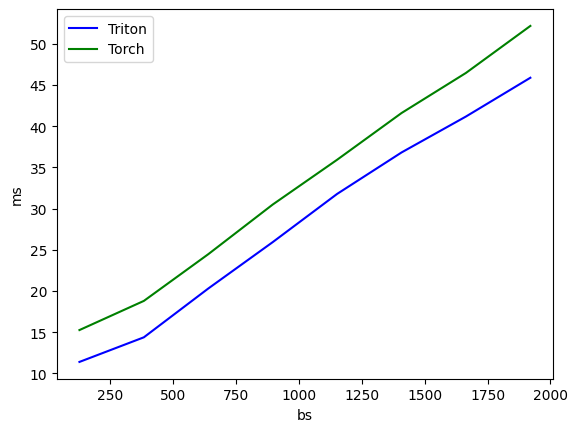

copy:
       bs     Triton      Torch
0   128.0  11.398242  15.264449
1   384.0  14.384467  18.801847
2   640.0  20.305376  24.470296
3   896.0  25.931198  30.492637
4  1152.0  31.781923  35.927448
5  1408.0  36.812235  41.596070
6  1664.0  41.172698  46.461891
7  1920.0  45.877583  52.166060


In [25]:
# 基本差不过
run_benchmark(triton_copyv1, 8196)

## 第二种情况
- 行级别的操作，比如softmax，max，min，mean之类的操作
- 一次读取一行
- 下面的例子都是假设copy函数是行级别的操作，必须每个程序处理一行

### 直接处理一行
- 适用于维度小的，比如layer_norm的维度一般不大

In [5]:
@triton.jit
def _copyv2(X, Y,
          stride_xm, stride_xn,
          N, BLOCK_SIZE: tl.constexpr):
    # tl.program_id(axis)就是去查看，当前是哪个程序
    # 比如grid是[10,20]， tl.program_id(0)可能是0-9中的某个数字，tl.program_id(1)是0-19
    # 这个id号，主要是用去区分，该程序是计算哪个部分，程序之间不能重复计算
    pid = tl.program_id(0)
    # 切换到指定行的偏置
    offset = pid * stride_xm
    X += offset
    Y += offset
    # arange中除了0，传参时都要在后面加tl.constexpr，不然报错，并且必须是2的指数倍
    cols = tl.arange(0, BLOCK_SIZE)
    # 将指针变为向量，对应一连串在内存上的位置
    x_ptrs = X + cols
    y_ptrs = Y + cols
    # 设置mask，这个直接让cols < N就行了，也就是确保列id号不超过N就行了
    mask = cols < N
    # 读取和写入都要传入mask, other表示mask的内容用什么表示，一般用0
    # 但是如果是max函数，所有数都小于0，那0成最大值了，显然是不对的，因此要设为 -floaf('inf')，需要看情况而定
    x = tl.load(x_ptrs, mask=mask, other=0.)
    tl.store(y_ptrs, x, mask=mask)
    

def triton_copyv2(x):
    # 比如处理的是最后一个维度，其它维度直接拉平就行了
    y = torch.empty_like(x)
    N = x.shape[-1]
    x = x.view(-1, N)
    M = x.size(0)
    BLOCK_SIZE = triton.next_power_of_2(N)
    # 一共需要处理M行，启动M个程序就行了
    grid = (M,)
    _copyv2[grid](x, y,
                # 我一般直接把stride都传进来，不管用的用不上，看个人习惯
                *x.stride(),
                N, BLOCK_SIZE,  
                num_stages=1, num_warps=8,          
    )
    # num_stages=1, num_warps=8,这两个参数会被triton.jit处理，定义函数时不用写
    # 我对这些了解也不多，网上也没啥太清楚的解释，大家就瞎试试就行了，比如（1，8），（4，8），（4，4）
    return y
device = 'cuda:0'
dtype = torch.float16
z,h,m,d = 8,8,128,4
a = torch.randn(z,h,m,d, device=device, dtype=dtype)
b = triton_copyv2(a)
torch.allclose(a,b)


True

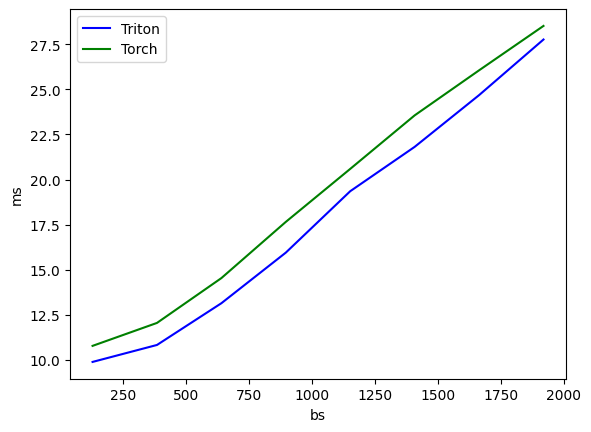

copy:
       bs     Triton      Torch
0   128.0   9.878857  10.769634
1   384.0  10.819910  12.042897
2   640.0  13.136650  14.530841
3   896.0  15.943799  17.649246
4  1152.0  19.351099  20.589350
5  1408.0  21.810982  23.558162
6  1664.0  24.681533  26.057823
7  1920.0  27.767481  28.521638


In [6]:
run_benchmark(triton_copyv2, 4096)

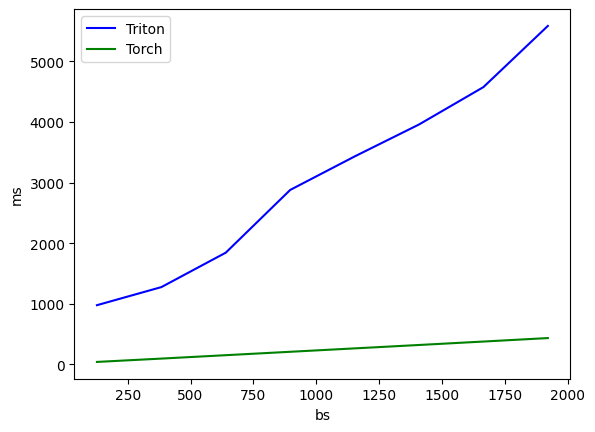

copy:
       bs       Triton       Torch
0   128.0   978.091121   42.157639
1   384.0  1276.381850   97.134776
2   640.0  1844.656825  153.237522
3   896.0  2879.348516  209.385291
4  1152.0  3431.516647  265.475810
5  1408.0  3959.253311  321.640611
6  1664.0  4576.003075  378.303647
7  1920.0  5585.048199  435.652405


In [7]:
# 当dim足够大时，一次load进这么多，效率反而低，应该多次load和store
run_benchmark(triton_copyv2, 88888)

### 大dim，dim分块处理

In [8]:
@triton.jit
def _copyv3(X, Y,
          stride_xm, stride_xn,
          N, BLOCK_SIZE: tl.constexpr):
    # tl.program_id(axis)就是去查看，当前是哪个程序
    # 比如grid是[10,20]， tl.program_id(0)可能是0-9中的某个数字，tl.program_id(1)是0-19
    # 这个id号，主要是用去区分，该程序是计算哪个部分，程序之间不能重复计算
    pid = tl.program_id(0)
    # 切换到指定行的偏置
    offset = pid * stride_xm
    X += offset
    Y += offset
    # arange中除了0，传参时都要在后面加tl.constexpr，不然报错，并且必须是2的指数倍
    cols = tl.arange(0, BLOCK_SIZE)
    for start_n in tl.range(0, N, BLOCK_SIZE):
        x_ptrs = X + cols + start_n
        y_ptrs = Y + cols + start_n
        # 设置mask，这个直接让cols < N就行了，也就是确保列id号不超过N就行了
        mask = cols + start_n < N
        # 读取和写入都要传入mask, other表示mask的内容用什么表示，一般用0
        # 但是如果是max函数，所有数都小于0，那0成最大值了，显然是不对的，因此要设为 -floaf('inf')，需要看情况而定
        x = tl.load(x_ptrs, mask=mask, other=0.)
        tl.store(y_ptrs, x, mask=mask)
    

def triton_copyv3(x):
    # 比如处理的是最后一个维度，其它维度直接拉平就行了
    y = torch.empty_like(x)
    N = x.shape[-1]
    x = x.view(-1, N)
    M = x.size(0)
    # 限制最大块的大小，比如1024，2048，4096都瞎试试，试多了就有经验了
    BLOCK_SIZE = min(triton.next_power_of_2(N), 4096)
    # 一共需要处理M行，启动M个程序就行了
    grid = (M,)
    _copyv3[grid](x, y,
                # 我一般直接把stride都传进来，不管用的用不上，看个人习惯
                *x.stride(),
                N, BLOCK_SIZE,  
                num_stages=1, num_warps=8,          
    )
    # num_stages=1, num_warps=8,这两个参数会被triton.jit处理，定义函数时不用写
    # 我对这些了解也不多，网上也没啥太清楚的解释，大家就瞎试试就行了，比如（1，8），（4，8），（4，4）
    return y
device = 'cuda:0'
dtype = torch.float16
z,h,m,d = 8,8,128,4096*4
a = torch.randn(z,h,m,d, device=device, dtype=dtype)
b = triton_copyv3(a)
torch.allclose(a,b)


True

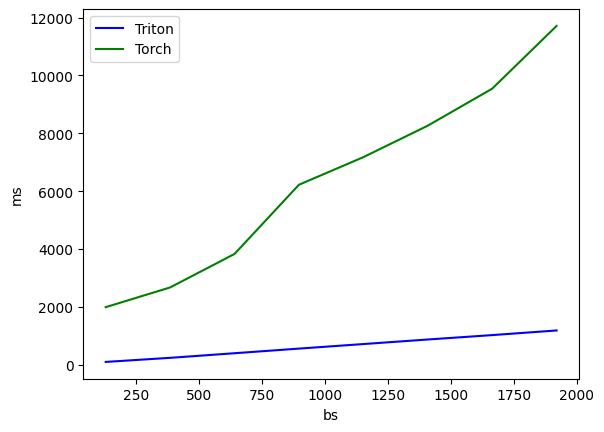

copy:
       bs       Triton         Torch
0   128.0    99.610806   1992.164254
1   384.0   240.886346   2673.571587
2   640.0   400.112152   3831.652880
3   896.0   559.908330   6223.565102
4  1152.0   717.013896   7177.392006
5  1408.0   874.758363   8265.228271
6  1664.0  1026.642084   9544.700623
7  1920.0  1186.966658  11713.040352


In [16]:
# func2的名字是torch，分块后，效果提升非常明显
run_benchmark(triton_copyv3, 188888, func2=triton_copyv2)

- 当dim小，bs大时，一次处理一行又会变得效率低下，就像是起了1w个程序，然后让每个程序就算个1+1，启动的时间比计算都长了，浪费资源

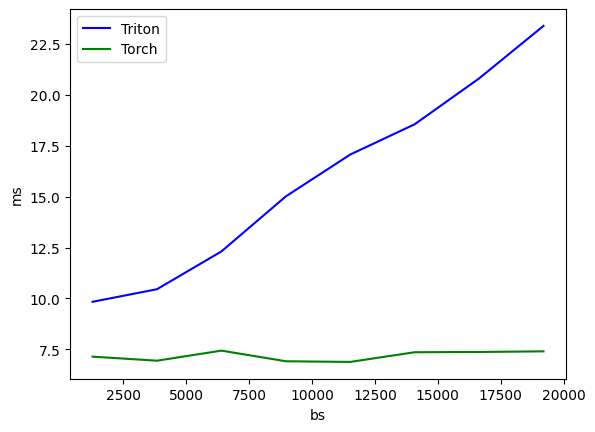

copy:
        bs     Triton     Torch
0   1280.0   9.832950  7.137127
1   3840.0  10.450766  6.938423
2   6400.0  12.306792  7.432908
3   8960.0  15.010898  6.910362
4  11520.0  17.068444  6.877947
5  14080.0  18.555598  7.354601
6  16640.0  20.807326  7.366918
7  19200.0  23.389259  7.397356


In [17]:
run_benchmark(triton_copyv2, 2, base=1280)

### 小dim，行(row)按块处理

In [ ]:
@triton.jit
def _copyv4(X, Y,
          stride_xm, stride_xn,
          M, N, BLOCK_M:tl.constexpr, BLOCK_N:tl.constexpr,):
    # tl.program_id(axis)就是去查看，当前是哪个程序
    # 比如grid是[10,20]， tl.program_id(0)可能是0-9中的某个数字，tl.program_id(1)是0-19
    # 这个id号，主要是用去区分，该程序是计算哪个部分，程序之间不能重复计算
    pid = tl.program_id(0)
    # 切换到指定行的偏置
    row_offset = pid * BLOCK_M * stride_xm
    X += row_offset 
    Y += row_offset
    rows = tl.arange(0, BLOCK_M)
    cols = tl.arange(0, BLOCK_N)
    row_mask = rows + pid * BLOCK_M < M
    col_mask = cols < N
    # 取都是True的
    mask = row_mask[:, None] & col_mask[None, :]

    ptrs = (rows * stride_xm)[:, None] + cols[None, :]
    x_ptrs = X + ptrs
    y_ptrs = Y + ptrs
    x = tl.load(x_ptrs, mask=mask, other=0.)
    tl.store(y_ptrs, x, mask=mask)
    

def triton_copyv4(x):
    # 比如处理的是最后一个维度，其它维度直接拉平就行了
    y = torch.empty_like(x)
    N = x.shape[-1]
    x = x.view(-1, N)
    M = x.size(0)
    # 随便设置一下，最好根据N的大小设置,例如；
    BLOCK_M = 64
    if N <= 128:
        BLOCK_M = 128
    if N <= 64:
        BLOCK_M = 256
    if N <= 32:
        BLOCK_M = 512
    # 但是不超过数据的行数
    BLOCK_M = min(triton.next_power_of_2(M), BLOCK_M)
    BLOCK_N = triton.next_power_of_2(N)
    grid = (triton.cdiv(M, BLOCK_M),)
    _copyv4[grid](x, y,
                # 我一般直接把stride都传进来，不管用的用不上，看个人习惯
                *x.stride(),
                M, N, BLOCK_M, BLOCK_N, 
                num_stages=1, num_warps=8,          
    )
    # num_stages=1, num_warps=8,这两个参数会被triton.jit处理，定义函数时不用写
    # 我对这些了解也不多，网上也没啥太清楚的解释，大家就瞎试试就行了，比如（1，8），（4，8），（4，4）
    return y
device = 'cuda:0'
dtype = torch.float16
z,h,m,d = 8,8,128,32
a = torch.randn(z,h,m,d, device=device, dtype=dtype)
b = triton_copyv4(a)
torch.allclose(a,b)


True

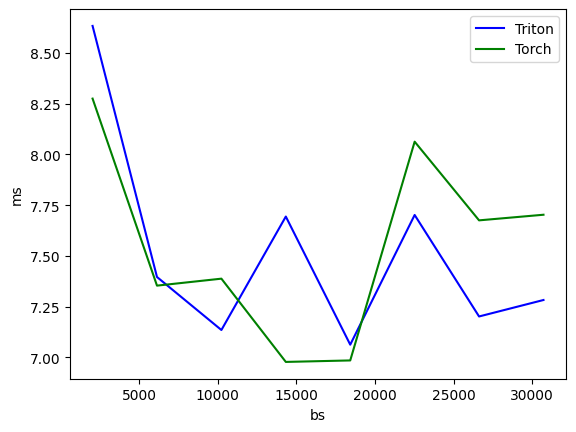

copy:
        bs    Triton     Torch
0   2048.0  8.633647  8.275350
1   6144.0  7.395995  7.353414
2  10240.0  7.134666  7.387747
3  14336.0  7.693956  6.977326
4  18432.0  7.062311  6.984652
5  22528.0  7.701734  8.063068
6  26624.0  7.201376  7.675190
7  30720.0  7.282572  7.702884


In [19]:
# 加速效果十分明显
run_benchmark(triton_copyv4, 4, base=2048)

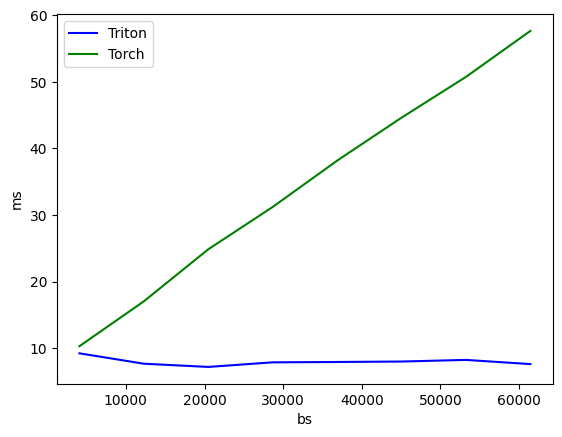

copy:
        bs    Triton      Torch
0   4096.0  9.206822  10.277709
1  12288.0  7.644529  17.027330
2  20480.0  7.163119  24.847358
3  28672.0  7.852532  31.207185
4  36864.0  7.905287  38.171496
5  45056.0  7.973073  44.630144
6  53248.0  8.218250  50.760373
7  61440.0  7.586741  57.671968


In [20]:
# func是torch
run_benchmark(triton_copyv4, 4, base=4096, func2=triton_copyv2)

### 整合
- 将v3和v4融合在一起，既能处理大的dim也能处理小的
- 性能与torch实现差不多

In [3]:
@triton.jit
def _copyv3(X, Y,
          stride_xm, stride_xn,
          N, BLOCK_SIZE: tl.constexpr):
    # tl.program_id(axis)就是去查看，当前是哪个程序
    # 比如grid是[10,20]， tl.program_id(0)可能是0-9中的某个数字，tl.program_id(1)是0-19
    # 这个id号，主要是用去区分，该程序是计算哪个部分，程序之间不能重复计算
    pid = tl.program_id(0)
    # 切换到指定行的偏置
    offset = pid * stride_xm
    X += offset
    Y += offset
    # arange中除了0，传参时都要在后面加tl.constexpr，不然报错，并且必须是2的指数倍
    cols = tl.arange(0, BLOCK_SIZE)
    for start_n in tl.range(0, N, BLOCK_SIZE):
        x_ptrs = X + cols + start_n
        y_ptrs = Y + cols + start_n
        # 设置mask，这个直接让cols < N就行了，也就是确保列id号不超过N就行了
        mask = cols + start_n < N
        # 读取和写入都要传入mask, other表示mask的内容用什么表示，一般用0
        # 但是如果是max函数，所有数都小于0，那0成最大值了，显然是不对的，因此要设为 -floaf('inf')，需要看情况而定
        x = tl.load(x_ptrs, mask=mask, other=0.)
        tl.store(y_ptrs, x, mask=mask)
    


@triton.jit
def _copyv4(X, Y,
          stride_xm, stride_xn,
          M, N, BLOCK_M:tl.constexpr, BLOCK_N:tl.constexpr,):
    # tl.program_id(axis)就是去查看，当前是哪个程序
    # 比如grid是[10,20]， tl.program_id(0)可能是0-9中的某个数字，tl.program_id(1)是0-19
    # 这个id号，主要是用去区分，该程序是计算哪个部分，程序之间不能重复计算
    pid = tl.program_id(0)
    # 切换到指定行的偏置
    offset = pid * stride_xm
    row_offset = pid * BLOCK_M * stride_xm
    X += row_offset 
    Y += row_offset
    rows = tl.arange(0, BLOCK_M)
    cols = tl.arange(0, BLOCK_N)
    row_mask = rows + pid * BLOCK_M < M
    col_mask = cols < N
    # 取都是True的
    mask = row_mask[:, None] & col_mask[None, :]

    ptrs = (rows * stride_xm)[:, None] + cols[None, :]
    x_ptrs = X + ptrs
    y_ptrs = Y + ptrs
    x = tl.load(x_ptrs, mask=mask, other=0.)
    tl.store(y_ptrs, x, mask=mask)
    

def triton_copyv5(x):
    # 比如处理的是最后一个维度，其它维度直接拉平就行了
    y = torch.empty_like(x)
    N = x.shape[-1]
    x = x.view(-1, N)
    M = x.size(0)

    if N >=128:
        BLOCK_SIZE = min(triton.next_power_of_2(N), 4096)
        # 一共需要处理M行，启动M个程序就行了
        grid = (M,)
        _copyv3[grid](x, y,
                    # 我一般直接把stride都传进来，不管用的用不上，看个人习惯
                    *x.stride(),
                    N, BLOCK_SIZE,  
                    num_stages=1, num_warps=8,          
        )
    else:
        if N < 128:
            BLOCK_M = 256
        if N <= 32:
            BLOCK_M = 512
        # 但是不超过数据的行数
        BLOCK_M = min(triton.next_power_of_2(M), BLOCK_M)
        BLOCK_N = triton.next_power_of_2(N)
        grid = (triton.cdiv(M, BLOCK_M),)
        _copyv4[grid](x, y,
                    # 我一般直接把stride都传进来，不管用的用不上，看个人习惯
                    *x.stride(),
                    M, N, BLOCK_M, BLOCK_N, 
                    num_stages=1, num_warps=8,          
        )
    # num_stages=1, num_warps=8,这两个参数会被triton.jit处理，定义函数时不用写
    # 我对这些了解也不多，网上也没啥太清楚的解释，大家就瞎试试就行了，比如（1，8），（4，8），（4，4）
    return y
device = 'cuda:0'
dtype = torch.float16
z,h,m,d = 8,8,128,32
a = torch.randn(z,h,m,d, device=device, dtype=dtype)
b = triton_copyv5(a)
torch.allclose(a,b)


True

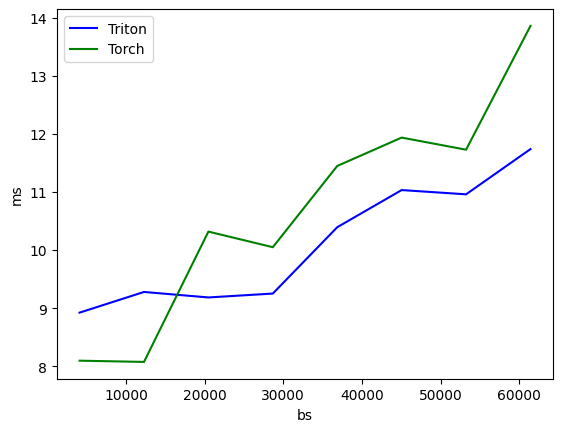

copy:
        bs     Triton      Torch
0   4096.0   8.923284   8.095907
1  12288.0   9.279348   8.074531
2  20480.0   9.184898  10.318725
3  28672.0   9.251785  10.050161
4  36864.0  10.394151  11.449247
5  45056.0  11.034223  11.937859
6  53248.0  10.960785  11.729388
7  61440.0  11.739988  13.860912


In [4]:
run_benchmark(triton_copyv5, 32, base=4096)

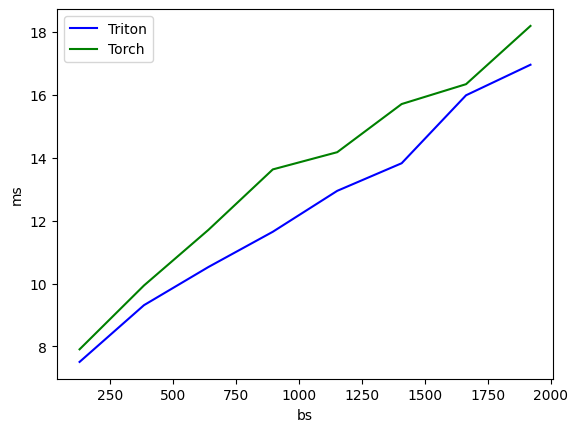

copy:
       bs     Triton      Torch
0   128.0   7.506860   7.907231
1   384.0   9.311414   9.937327
2   640.0  10.524097  11.705142
3   896.0  11.645162  13.627600
4  1152.0  12.946101  14.175203
5  1408.0  13.823579  15.705960
6  1664.0  15.984800  16.337825
7  1920.0  16.955543  18.189542


In [8]:
run_benchmark(triton_copyv5, 2048, base=128)

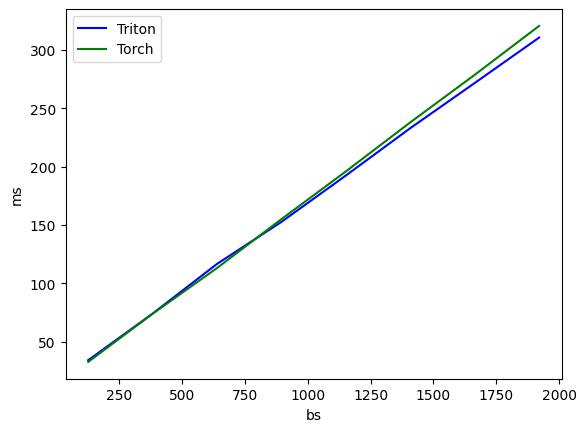

copy:
       bs      Triton       Torch
0   128.0   34.122910   32.665662
1   384.0   74.035019   73.903084
2   640.0  116.601288  113.081656
3   896.0  152.595952  154.965445
4  1152.0  192.306727  195.813745
5  1408.0  232.861906  237.817094
6  1664.0  271.527767  278.538167
7  1920.0  310.425729  320.418745


In [7]:
run_benchmark(triton_copyv5, 8192*8, base=128)

# make_block_ptr函数
- 讲解一个快速生成block的函数，但需要一定条件
- block只能控制一个维度防止溢出，因此必须保证一个维度必须是2的指数倍，如head_dim=64, 128都是可以的，而seq_len是多少无所谓

In [ ]:
@triton.jit
def _copy(X, Y,  
          stride_b, stride_h, stride_m, stride_n,
          B, H, M, N: tl.constexpr, BLOCK_M:tl.constexpr,
          ):
    pid = tl.program_id(0)
    off_b = pid // H
    off_h = pid % H
    offset = off_b * stride_b + off_h * stride_h
    X += offset
    Y += offset

    X_ptrs = tl.make_block_ptr(
        base=X,       # 初始指针位置
        shape=(M, N), # 根据pid，定位到具体的b和h，比如x[i][j] 就是一个[M, N]的tensor
        offsets=(0,0),# 起始指针位置的偏置
        strides=(stride_m, stride_n), # 对应offset中，移动一个索引，在内存上需要移动的步数
        block_shape=(BLOCK_M, N), # (M,N)的tensor每次读取(BLOCK_M, N), 注意block_shape中的数，必须是tl.constexpr, 不然会报错
        order=(1,0) # 记住就行了， （1，0）就是[M,N]的张量，（0，1）就是转置[N, M]，需要把上面的除了base，全部反转，
                    # 比如shape=(N, M), strides=(stride_n, stride_m)， block_shape=(N, BLOCK_M)
    )

    Y_ptrs = tl.make_block_ptr(
        base=Y,       # 初始指针位置
        shape=(M, N), # 根据pid，定位到具体的b和h，比如x[i][j] 就是一个[M, N]的tensor
        offsets=(0,0),# 起始指针位置的偏置
        strides=(stride_m, stride_n), # 对应offset中，移动一个索引，在内存上需要移动的步数
        block_shape=(BLOCK_M, N), # (M,N)的tensor每次读取(BLOCK_M, N), 注意block_shape中的数，必须是tl.constexpr, 不然会报错
        order=(1,0) # 记住就行了， （1，0）就是[M,N]的张量，（0，1）就是转置[N, M]，需要把上面的除了base，全部反转，
                    # 比如shape=(N, M), strides=(stride_n, stride_m)， block_shape=(N, BLOCK_M)
                    # 两个矩阵做乘法的时候，另一个矩阵需要进行转置，不用在外部进行翻转
    )
    
    for start_m in tl.range(0, M, BLOCK_M):
        # 注意，如果传入的是block_ptr， 不需要设置mask和other
        # 配套的是boundary_check，M这个维度可能会溢出，因此，设置(0,)，如果N溢出，就是(1,), padding_option对应other
        x = tl.load(X_ptrs, boundary_check=(0,), padding_option='zero')
        # 同样，存储也需要设置boundary_check
        tl.store(Y_ptrs, x, boundary_check=(0,))

        # 当前block处理完，处理下一个block，移动block，在M维度上
        # 根据之前定义的stride进行移动
        X_ptrs = tl.advance(X_ptrs, offsets=(BLOCK_M, 0))
        Y_ptrs = tl.advance(Y_ptrs, offsets=(BLOCK_M, 0))

def copy(x):
    y = torch.empty_like(x)
    B, H, M, N = x.shape
    # assert math.log2(N).is_integer()
    BLOCK_M= min(16, triton.next_power_of_2(M))
    grid = lambda meta: (B*H,)
    # print(x.stride())
    _copy[grid](x, y,
            *x.stride(),
            B, H, M, N, BLOCK_M,      
    )

    return y

In [29]:
device = 'cuda:0'
dtype = torch.float16
z,h,m,d = 8,8,100,32
a = torch.randn(z,h,m,d, device=device, dtype=dtype)
b = copy(a)
torch.allclose(a,b)

True

In [ ]:
device = 'cuda:0'
dtype = torch.float16
z,h,m,d = 8,8,100, 50 # d不是2的指数倍就会报错， m无所谓，因此make_block_ptr必须保证一个维度是2的指数倍，不然就需要padding
a = torch.randn(z,h,m,d, device=device, dtype=dtype)
b = copy(a)
torch.allclose(a,b)

loc("/tmp/ipykernel_2205416/2949310122.py":36:20): error: Number of elements must be power-of-two, but %19 = "tt.load"(%arg9) <{boundaryCheck = array<i32: 0>, cache = 1 : i32, evict = 1 : i32, isVolatile = false, operandSegmentSizes = array<i32: 1, 0, 0>, padding = 1 : i32}> : (!tt.ptr<tensor<16x50xf16>>) -> tensor<16x50xf16> doesn't follow the rule (800) elements


RuntimeError: PassManager::run failed

In [ ]:
@triton.jit
def _copy(X, Y,
          stride_xm, stride_xn,
          N, BLOCK_SIZE: tl.constexpr):
    # tl.program_id(axis)就是去查看，当前是哪个程序
    # 比如grid是[10,20]， tl.program_id(0)可能是0-9中的某个数字，tl.program_id(1)是0-19
    # 这个id号，主要是用去区分，该程序是计算哪个部分，程序之间不能重复计算
    pid = tl.program_id(0)
    # 切换到指定行的偏置
    offset = pid * stride_xm
    X += offset
    Y += offset
    # arange中除了0，传参时都要在后面加tl.constexpr，不然报错，并且必须是2的指数倍
    cols = tl.arange(0, BLOCK_SIZE)
    # 将指针变为向量，对应一连串在内存上的位置
    x_ptrs = X + cols
    y_ptrs = Y + cols
    # 设置mask，这个直接让cols < N就行了，也就是确保列id号不超过N就行了
    mask = cols < N
    # 读取和写入都要传入mask, other表示mask的内容用什么表示，一般用0
    # 但是如果是max函数，所有数都小于0，那0成最大值了，显然是不对的，因此要设为 -floaf('inf')，需要看情况而定
    x = tl.load(x_ptrs, mask=mask, other=0.)
    y = tl.store(y_ptrs, x, mask=mask)
    

def triton_copy(x):
    # 比如处理的是最后一个维度，其它维度直接拉平就行了
    y = torch.empty_like(x)
    N = x.shape[-1]
    x = x.view(-1, N)
    M = x.size(0)
    BLOCK_SIZE = triton.next_power_of_2(N)
    # 一共需要处理M行，启动M个程序就行了
    grid = (M,)
    _copy[grid](x, y,
                # 我一般直接把stride都传进来，不管用的用不上，看个人习惯
                *x.stride(),
                N, BLOCK_SIZE,  
                num_stages=1, num_warps=8,          
    )
    # num_stages=1, num_warps=8,这两个参数会被triton.jit处理，定义函数时不用写
    # 我对这些了解也不多，网上也没啥太清楚的解释，大家就瞎试试就行了，比如（1，8），（4，8），（4，4）
    return y
device = 'cuda:0'
dtype = torch.float16
z,h,m,d = 8,8,128,4
a = torch.randn(z,h,m,d, device=device, dtype=dtype)
b = triton_copy(a)
torch.allclose(a,b)
